In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from skimage.transform import resize

In [2]:
X = sorted(glob("C:\\Users\\gh464\Documents\Ph2 training data\\bent_noisematched_allsize_emptytrench\\convolutions\\*.tif"))
Y = sorted(glob("C:\\Users\\gh464\Documents\Ph2 training data\\bent_noisematched_allsize_emptytrench\\masks\\*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [4]:
requires_resize = True
resize_shape = (256,64)
if requires_resize:
    Y = [resize(y,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None).astype(int) for y in tqdm(Y)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

100%|████████████████████████████████████████████████████████████████████████████| 7747/7747 [00:05<00:00, 1447.51it/s]


In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y.astype(int)) for y in tqdm(Y)]

100%|████████████████████████████████████████████████████████████████████████████| 7747/7747 [00:03<00:00, 1979.55it/s]


In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.3 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 7747
- training:       5423
- validation:     2324


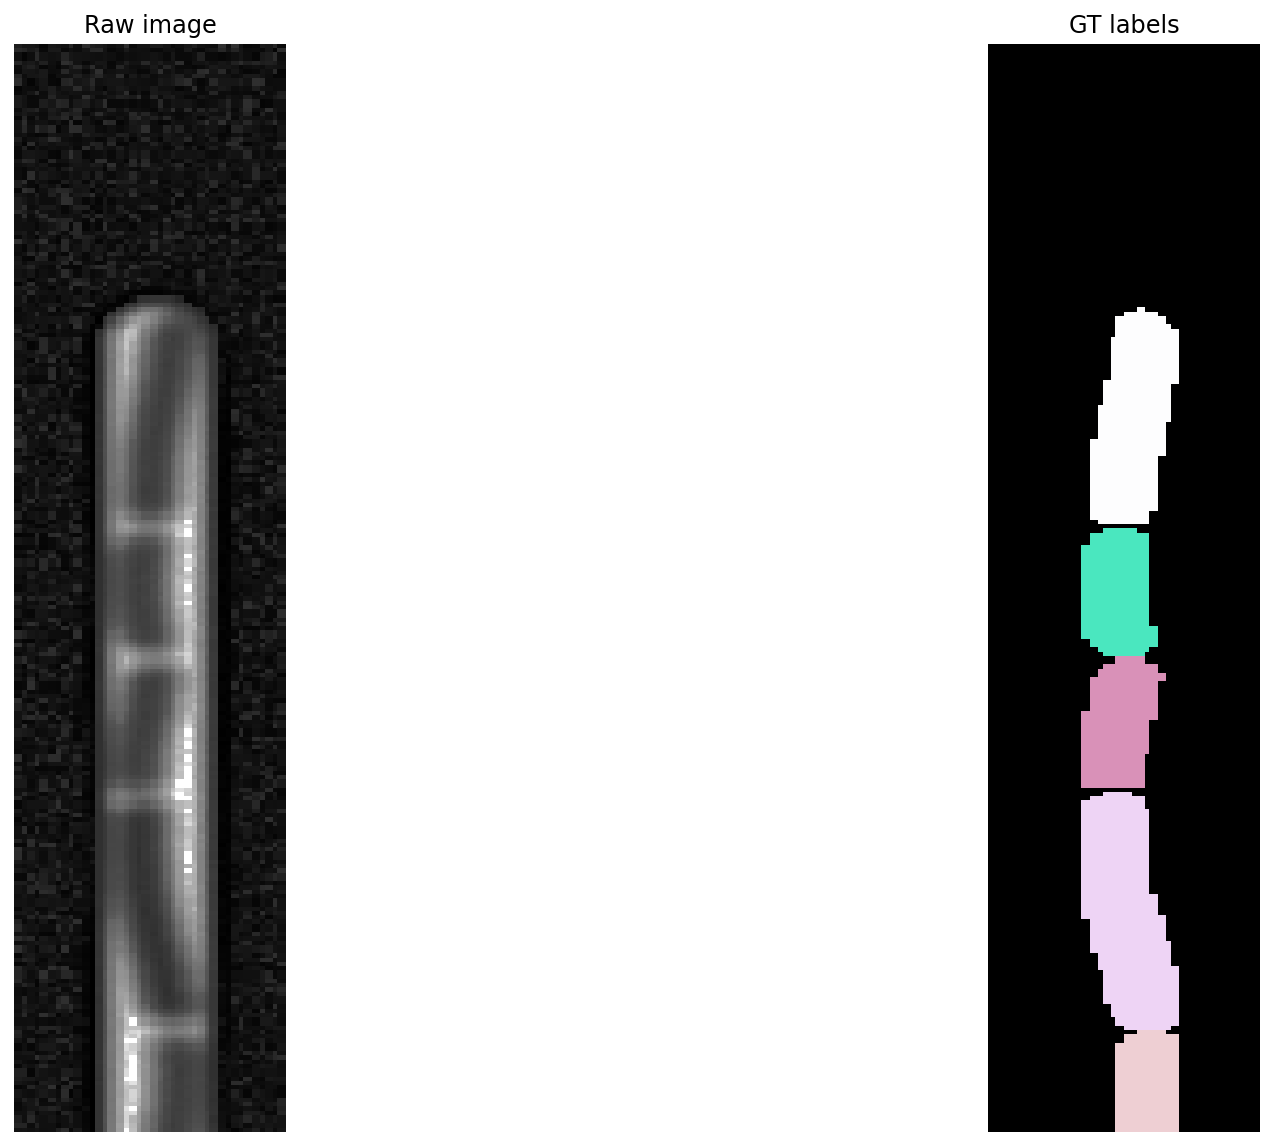

In [7]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
np.random.seed(42)
data = StarDistData2D(X,Y,batch_size=1,n_rays=120,patch_size=X[i].shape,shape_completion=False,length=1)

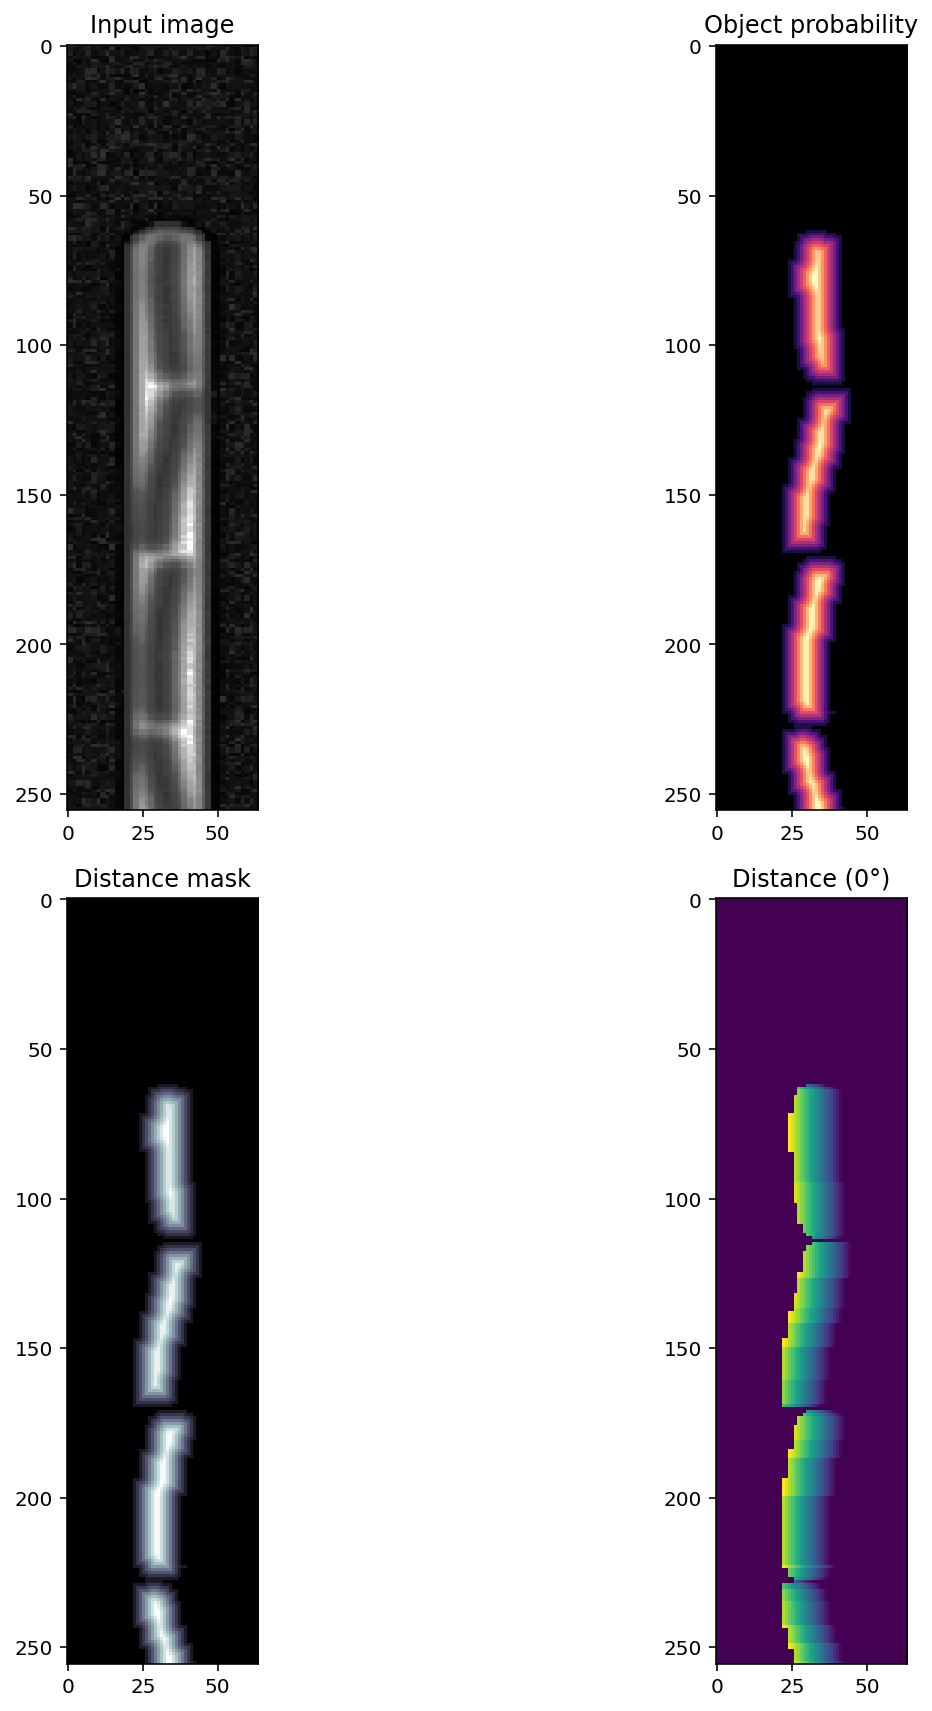

In [9]:
(img,), (prob,dist) = data[0]
dist, dist_mask = dist[...,:-1], dist[...,-1:]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

In [10]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [ ]:
unet_n_depths = [5,6,7,8]
unet_activations = ["relu"]
unet_last_activations = ["sigmoid"]
for unet_n_depth in unet_n_depths:
    for unet_activation in unet_activations:
        for unet_last_activation in unet_last_activations:
            conf = Config2D(
                n_channel_in=n_channel, 
                train_shape_completion=False, 
                train_patch_size=resize_shape, 
                use_gpu=True,
                train_background_reg = 0.000001,
                train_learning_rate=0.0002,
                unet_batch_norm = True,
                unet_dropout=0.3,
                train_epochs=100,
                unet_n_depth=unet_n_depth,
                n_rays = 128,
                unet_activation = unet_activation,
                unet_last_activation = unet_last_activation
            )
            #print(conf)
            #vars(conf)
            model = StarDist2D(conf, name='stardist_no_shape_completion', basedir='bent_noisematched_allsize_empty_und{}_una{}_unla{}'.format(unet_n_depth,unet_activation,unet_last_activation))

            model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

base_model.py (148): output path for model already exists, files may be overwritten: C:\Users\gh464\Documents\GitHub\SYMPTOMM2\prototyping\deep_learning\StarDist\bent_noisematched_allsize_empty_und5_unarelu_unlasigmoid\stardist_no_shape_completion


Using default values: prob_thresh=0.5, nms_thresh=0.4.


optimizer_v2.py (374): The `lr` argument is deprecated, use `learning_rate` instead.


Error: Could not find scikit-tensor which is needed separable approximations...
pip install scikit-tensor-py3
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x000002BD5C90E430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x000002BD5C90E430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x000002BD5C90E430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 39s 262ms/step - loss: 2.3859 - prob_loss: 0.1637 - dist_loss: 11.1110 - prob_kld: 0.0689 - dist_relevant_mae: 11.1110 - dist_relevant_mse: 183.1841 - dist_dist_iou_metric: 0.0065 - val_loss: 1.9486 - val_prob_loss: 0.2661 - val_dist_loss: 8.4122 - val_prob_kld: 0.1713 - val_dist_rel

In [ ]:
unet_n_depth